<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-Study:-Northwind-Traders" data-toc-modified-id="Case-Study:-Northwind-Traders-1">Case Study: Northwind Traders</a></span><ul class="toc-item"><li><span><a href="#convert-sql-database-tables-into-pandas-dataframes" data-toc-modified-id="convert-sql-database-tables-into-pandas-dataframes-1.1">convert sql database tables into pandas dataframes</a></span><ul class="toc-item"><li><span><a href="#check-for-normality-in-the-experiment-and-control-samples" data-toc-modified-id="check-for-normality-in-the-experiment-and-control-samples-1.1.1">check for normality in the experiment and control samples</a></span></li></ul></li><li><span><a href="#Question-1:" data-toc-modified-id="Question-1:-1.2">Question 1:</a></span></li><li><span><a href="#Question-2" data-toc-modified-id="Question-2-1.3">Question 2</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Is-there-a-region-that-outperforms-the-others-in-terms-of-order-quantities?" data-toc-modified-id="Is-there-a-region-that-outperforms-the-others-in-terms-of-order-quantities?-1.3.0.1">Is there a region that outperforms the others in terms of order quantities?</a></span></li></ul></li><li><span><a href="#check-for-normality" data-toc-modified-id="check-for-normality-1.3.1">check for normality</a></span><ul class="toc-item"><li><span><a href="#stats-normaltest-confirms-the-distributions-are-not-normalLets-re-sample-to-gather-distribution-means-that-will-satisfy-normality-assumptions" data-toc-modified-id="stats-normaltest-confirms-the-distributions-are-not-normalLets-re-sample-to-gather-distribution-means-that-will-satisfy-normality-assumptions-1.3.1.1">stats normaltest confirms the distributions are not normal<br>Lets re-sample to gather distribution means that will satisfy normality assumptions</a></span></li></ul></li><li><span><a href="#combining-multiple-Series-into-a-DataFrame:-lessons-learned----the-Series-must-have-names-(see-example-above)and-you-must-specify-the-horizontal-axis" data-toc-modified-id="combining-multiple-Series-into-a-DataFrame:-lessons-learned----the-Series-must-have-names-(see-example-above)and-you-must-specify-the-horizontal-axis-1.3.2">combining multiple Series into a DataFrame: <br>lessons learned -- the Series must have names (see example above)<br>and you must specify the horizontal axis</a></span></li><li><span><a href="#need-to-run-ANOVA-here" data-toc-modified-id="need-to-run-ANOVA-here-1.3.3">need to run ANOVA here</a></span></li></ul></li><li><span><a href="#Question-3" data-toc-modified-id="Question-3-1.4">Question 3</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#are-there-any-salespeople-that-stand-out?" data-toc-modified-id="are-there-any-salespeople-that-stand-out?-1.4.0.1">are there any salespeople that stand out?</a></span></li></ul></li></ul></li><li><span><a href="#Question-4" data-toc-modified-id="Question-4-1.5">Question 4</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#are-there-any-categories-we-should-think-about-dicontinuing-or-expanding-on?" data-toc-modified-id="are-there-any-categories-we-should-think-about-dicontinuing-or-expanding-on?-1.5.0.1">are there any categories we should think about dicontinuing or expanding on?</a></span></li></ul></li></ul></li></ul></li></ul></div>

[link to cell in question](#link_to_cell_in_question)

[link to pd.melt](#link_to_pd.melt)


# Case Study: Northwind Traders


Four questions to consider:<br>
1. Do discounted items sell in greater quantites than non-discounted items?  And if so, does the level of discount have an impact?
2. Are there any days per week that stand out?
3. Do all regions perform equally in terms of quantities sold?  And are there any products that differ in quanitty sold by region?
4. Are all salespeople created equal or do we have any under/over-performers?  And does time in job play a role?


In [100]:
# import packages and modules


import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
import scipy.stats as stats
from math import sqrt
import math
import copy
import statsmodels.api as sm             #for ANOVA
from statsmodels.formula.api import ols  #for ANOVA
from sklearn import preprocessing

import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import session, sessionmaker
from sqlalchemy import inspect # so we can perform high level investigations

from datetime import timedelta

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('seaborn')
from matplotlib import style

pd.set_option('display.max_columns', None)

In [3]:
# creating an engine object and a session to connect and work with the Northwind sql db

engine = create_engine("sqlite:///Northwind_small.sqlite", echo = True)
Session = sessionmaker(bind = engine)
session = Session
inspector = inspect(engine)

2019-05-20 09:05:23,145 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-20 09:05:23,161 INFO sqlalchemy.engine.base.Engine ()
2019-05-20 09:05:23,165 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-20 09:05:23,165 INFO sqlalchemy.engine.base.Engine ()


In [4]:
# lets have a look at the tables we will be working with and get to know them better

inspector.get_table_names()

2019-05-20 09:05:23,185 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-05-20 09:05:23,189 INFO sqlalchemy.engine.base.Engine ()


['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

In [5]:


from sqlalchemy import MetaData
from sqlalchemy.ext.automap import automap_base # creates a framework that clones the db structure so that it can generate a 
                                                  # a new model in which to map the db with its metadata, ie, column headings

In [6]:
# map the db table features with their headings

metadata = MetaData()
metadata.reflect(engine)
Base = automap_base(metadata = metadata)
Base.prepare()

Category, Customer, CustomerCustomerDemo, CustomerDemographic, Employee, EmployeeTerritory, Order, OrderDetail,\
Product, Region, Shipper, Supplier, Territory = \
Base.classes.Category,\
Base.classes.Customer,\
Base.classes.CustomerCustomerDemo,\
Base.classes.CustomerDemographic, \
Base.classes.Employee, \
Base.classes.EmployeeTerritory,\
Base.classes.Order,\
Base.classes.OrderDetail, \
Base.classes.Product, \
Base.classes.Region,\
Base.classes.Shipper, \
Base.classes.Supplier, \
Base.classes.Territory

2019-05-20 09:05:23,289 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-05-20 09:05:23,297 INFO sqlalchemy.engine.base.Engine ()
2019-05-20 09:05:23,301 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Category")
2019-05-20 09:05:23,305 INFO sqlalchemy.engine.base.Engine ()
2019-05-20 09:05:23,317 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Category' AND type = 'table'
2019-05-20 09:05:23,317 INFO sqlalchemy.engine.base.Engine ()
2019-05-20 09:05:23,325 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("Category")
2019-05-20 09:05:23,325 INFO sqlalchemy.engine.base.Engine ()
2019-05-20 09:05:23,329 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Category' AND type = 'table'
2019-05-20 09:05:23,333 INFO sqlalchemy.engine.base.Engin

##### converting each mapped table to a pandas dataframe

In [7]:
# converting each mapped table to a pandas dataframe

category_df= pd.read_sql_query("SELECT * FROM [category]", engine)
customer_df = pd.read_sql_query("SELECT * FROM [customer]", engine)
customerCustomerDemo_df = pd.read_sql_query("SELECT * FROM [customerCustomerDemo]", engine)
customerDemographic_df = pd.read_sql_query("SELECT * FROM [customerDemographic]", engine)
employee_df = pd.read_sql_query("SELECT * FROM [employee]", engine)
employeeTerritory_df = pd.read_sql_query("SELECT * FROM [employeeTerritory]", engine)
order_df = pd.read_sql_query("SELECT * FROM [order]", engine)
orderDetail_df = pd.read_sql_query("SELECT * FROM [orderDetail]", engine)
product_df = pd.read_sql_query("SELECT * FROM [product]", engine)
region_df = pd.read_sql_query("SELECT * FROM [region]", engine)
shipper_df = pd.read_sql_query("SELECT * FROM [shipper]", engine)
supplier_df = pd.read_sql_query("SELECT * FROM [supplier]", engine)
territory_df = pd.read_sql_query("SELECT * FROM [territory]", engine)

2019-05-20 09:05:24,182 INFO sqlalchemy.engine.base.Engine SELECT * FROM [category]
2019-05-20 09:05:24,186 INFO sqlalchemy.engine.base.Engine ()
2019-05-20 09:05:24,218 INFO sqlalchemy.engine.base.Engine SELECT * FROM [customer]
2019-05-20 09:05:24,218 INFO sqlalchemy.engine.base.Engine ()
2019-05-20 09:05:24,262 INFO sqlalchemy.engine.base.Engine SELECT * FROM [customerCustomerDemo]
2019-05-20 09:05:24,266 INFO sqlalchemy.engine.base.Engine ()
2019-05-20 09:05:24,282 INFO sqlalchemy.engine.base.Engine SELECT * FROM [customerDemographic]
2019-05-20 09:05:24,282 INFO sqlalchemy.engine.base.Engine ()
2019-05-20 09:05:24,298 INFO sqlalchemy.engine.base.Engine SELECT * FROM [employee]
2019-05-20 09:05:24,298 INFO sqlalchemy.engine.base.Engine ()
2019-05-20 09:05:24,322 INFO sqlalchemy.engine.base.Engine SELECT * FROM [employeeTerritory]
2019-05-20 09:05:24,326 INFO sqlalchemy.engine.base.Engine ()
2019-05-20 09:05:24,342 INFO sqlalchemy.engine.base.Engine SELECT * FROM [order]
2019-05-20 

In [48]:
employee_df.head(2)

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp


In [64]:
employee_df.HireDate.value_counts()

2025-10-17    2
2026-01-02    1
2024-04-01    1
2024-08-14    1
2024-05-01    1
2026-03-05    1
2025-05-03    1
2026-11-15    1
Name: HireDate, dtype: int64

looks like we have input errors, lets fix those

In [69]:
employee_df.replace({'HireDate':{'2025-10-17':'2005-10-17', '2026-01-02':'2006-01-02', '2024-04-01':'2004-04-01', '2024-08-14':'2004-08-14', '2024-05-01':'2004-05-01',
                                 '2026-03-05':'2006-03-05', '2025-05-03':'2005-05-03', '2026-11-15':'2006-11-15'}}, inplace = True)
employee_df.HireDate.value_counts()

2005-10-17    2
2006-01-02    1
2004-04-01    1
2006-03-05    1
2006-11-15    1
2005-05-03    1
2004-08-14    1
2004-05-01    1
Name: HireDate, dtype: int64

In [70]:
category_df.rename(columns = {"Id":"CategoryId"}, inplace = True)

cat_prod_df = pd.merge(category_df, product_df, how = 'outer', on = "CategoryId" )

cat_prod_df.rename(columns = {"Id": "ProductId"}, inplace = True)

cat_prod_OrDtl_df = pd.merge(cat_prod_df, orderDetail_df, how = 'outer', on = "ProductId")

order_df.rename(columns = {"Id" : "OrderId"}, inplace = True)

cat_prod_OrDtl_orders_df = pd.merge(cat_prod_OrDtl_df, order_df, how = 'outer', on = "OrderId" )

customer_df.rename(columns ={"Id": "CustomerId"}, inplace = True)

cat_prod_OrDtl_orders_cust_df = pd.merge(cat_prod_OrDtl_orders_df, customer_df, how = 'outer', on = "CustomerId")

employee_df.rename(columns = {'Id':'EmployeeId'}, inplace = True)

data = pd.merge(cat_prod_OrDtl_orders_cust_df, employee_df, how = 'outer', on = 'EmployeeId' )

data.head()

,CategoryId,CategoryName,Description,ProductId,ProductName,SupplierId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,OrderId,UnitPrice_y,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,CompanyName,ContactName,ContactTitle,Address_x,City_x,Region_x,PostalCode_x,Country_x,Phone,Fax,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address_y,City_y,Region_y,PostalCode_y,Country_y,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1.0,Beverages,"Soft drinks, coffees, teas, beers, and ales",1.0,Chai,1.0,10 boxes x 20 bags,18.0,39.0,0.0,10.0,0.0,10285/1,10285.0,14.4,45.0,0.2,QUICK,1.0,2012-08-20,2012-09-17,2012-08-26,2.0,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2004-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,6.0,Meat/Poultry,Prepared meats,53.0,Perth Pasties,24.0,48 pieces,32.8,0.0,0.0,0.0,1.0,10285/53,10285.0,26.2,36.0,0.2,QUICK,1.0,2012-08-20,2012-09-17,2012-08-26,2.0,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2004-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
2,8.0,Seafood,Seaweed and fish,40.0,Boston Crab Meat,19.0,24 - 4 oz tins,18.4,123.0,0.0,30.0,0.0,10285/40,10285.0,14.7,40.0,0.2,QUICK,1.0,2012-08-20,2012-09-17,2012-08-26,2.0,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2004-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
3,1.0,Beverages,"Soft drinks, coffees, teas, beers, and ales",2.0,Chang,1.0,24 - 12 oz bottles,19.0,17.0,40.0,25.0,0.0,10991/2,10991.0,19.0,50.0,0.2,QUICK,1.0,2014-04-01,2014-04-29,2014-04-07,1.0,38.51,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2004-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
4,1.0,Beverages,"Soft drinks, coffees, teas, beers, and ales",70.0,Outback Lager,7.0,24 - 355 ml bottles,15.0,15.0,10.0,30.0,0.0,10991/70,10991.0,15.0,20.0,0.2,QUICK,1.0,2014-04-01,2014-04-29,2014-04-07,1.0,38.51,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2004-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp


## <font color='lime'> Question 1 </font>
###### Do discounted items sell in greater quantites than non-discounted items?  And if so, does the level of discount have an impact?

##### Isolate the data we need 

In [9]:
# we will need Quanity and Discount columns to answer both parts of quesiotn 1

q1df = copy.deepcopy(orderDetail_df[["Quantity", "Discount"]])
q1df.head()

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


In [10]:
q1df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [11]:
# remove irrelevant discount levels based on the extremely low number of observations

q1df = copy.deepcopy(q1df[q1df.Discount.isin([ 0.05, 0.10, 0.20, 0.15, 0.25, 0.00])])

In [12]:
# check for null values

q1df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2147 entries, 0 to 2154
Data columns (total 2 columns):
Quantity    2147 non-null int64
Discount    2147 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.3 KB


##### Lets check for normality visually and with statistical tests 

In [13]:
# split the data between the control (no discount) and experiment group (having a discount)

q1_wDis = copy.deepcopy(q1df[q1df.Discount > 0.0])
q1_woDis = copy.deepcopy(q1df[q1df.Discount == 0.0])

print("number observations without discount:", len(q1_woDis))
print("number observations with discount :", len(q1_wDis))

wDisAvg = q1_wDis['Quantity'].mean()
print("avg. quantity sold with discount:" , wDisAvg)

wOdisAvg = q1_woDis['Quantity'].mean()
print("avg. quantity sold without a discount:" , wOdisAvg)

number observations without discount: 1317
number observations with discount : 830
avg. quantity sold with discount: 27.35421686746988
avg. quantity sold without a discount: 21.715261958997722


##### Visual checks for normality 

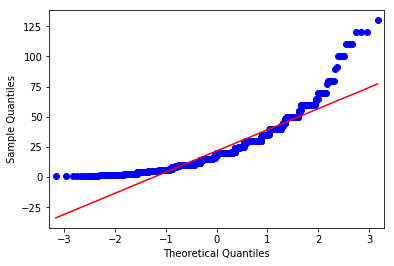

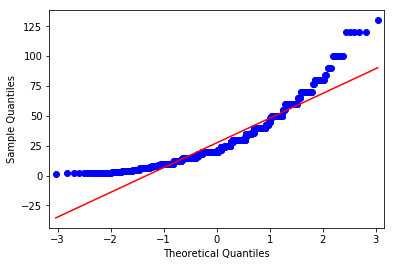

In [14]:
from statsmodels.graphics.gofplots import qqplot

wo_dis = qqplot(q1_woDis.Quantity, line = 's')
w_dis=qqplot(q1_wDis.Quantity, line = 's')

##### The Quanitle Quantile (QQ) plots above for the experiment and control group show a large deviation from the ideal normal distribution (the straight line). 

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


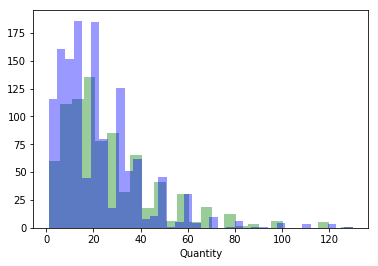

In [15]:
# kde turned off so we see actual frequency instead of normalized frequency

sns.distplot(q1_wDis.Quantity, kde = False, color = 'g', label = "w discount")
sns.distplot(q1_woDis.Quantity, kde = False, color = 'b', label = "wo discount")

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


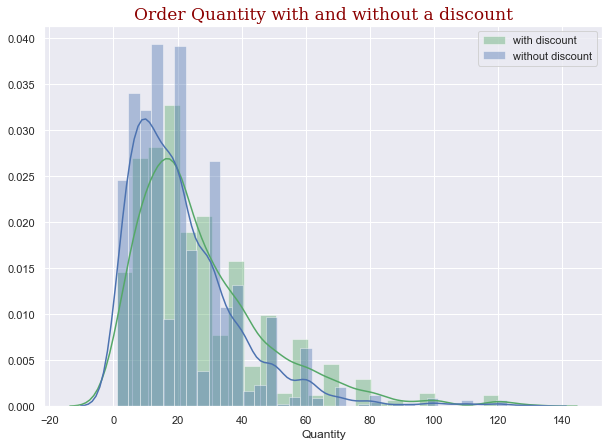

In [16]:
#plt.style.use("dark_background")
#sns.set_color_codes("bright")
sns.set(rc={'figure.figsize':(10,7)})
sns.distplot(q1_wDis.Quantity, color = "g", label = "with discount", norm_hist = False) 
sns.distplot(q1_woDis.Quantity, color = "b", label = "without discount", norm_hist = False) 

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 17,
        }

plt.title("Order Quantity with and without a discount", fontdict=font)
plt.legend()

###### The qq plots and historgrams look non-normal; lets conifrm with the stats normaltest method which performs a D'Aostino K**2 test that looks at skew (asymetry) and kurtosis (magnitude of observations present in a tail)

In [17]:
print(stats.normaltest(q1_wDis.Quantity))
print(stats.normaltest(q1_woDis.Quantity))

NormaltestResult(statistic=261.04626710761113, pvalue=2.0631145260149106e-57)
NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)


##### P-value for both sets is less than alpha of 0.05 so we reject the null that distribution is normal. <br> Now lets focus on getting our samples to fit a normal distribution<br>we will use the property of the Central Limit Theorem and sampling distribution of the mean

In [18]:
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)
    
    return sample

def create_sample_distribution(data, dist_size=2000, n=500):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = sum(sample) / len(sample)
        sample_dist.append(sample_mean)
    
    return sample_dist




In [19]:
q1_norm_wDis = pd.Series(create_sample_distribution(q1_wDis.Quantity))
q1_norm_woDis = pd.Series(create_sample_distribution(q1_woDis.Quantity))

###### now lets visually inspect the distribution of sample means for the control and experiment groups

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


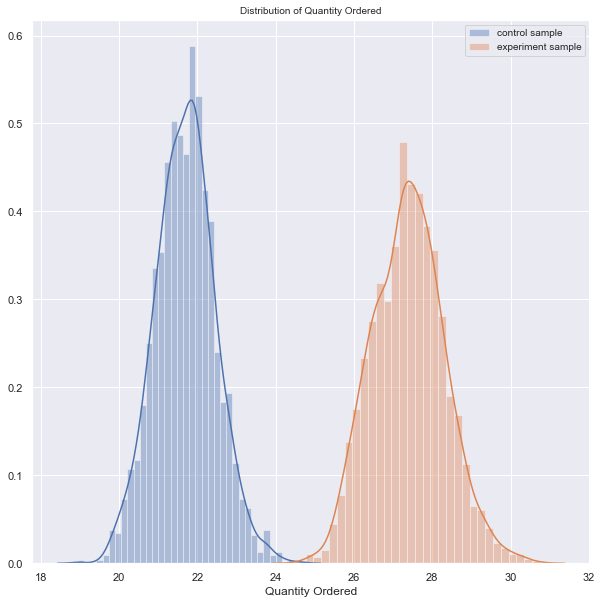

In [20]:
plt.figure(figsize = (10,10))
sns.distplot(q1_norm_woDis, label = "control sample")
sns.distplot(q1_norm_wDis, label = "experiment sample")
plt.title("Distribution of Quantity Ordered", fontsize= 10)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 10)

In [21]:
print(stats.normaltest(q1_norm_woDis))
print(stats.normaltest(q1_norm_wDis))

NormaltestResult(statistic=6.830151188671659, pvalue=0.0328739215253182)
NormaltestResult(statistic=8.598297381594984, pvalue=0.013580114969501277)


##### running a normal test on the new data we see we fail to reject the null that the distributions are normal <br> Our data now satisfies the normality assumption. 

## Question 1: 
##### Does offering a discount precipitate a meaningful difference in order quantity?<br> And if so, is there a discount level that stands out from the rest?

question 1 part a

$H_O$: Offering a discount does not change the average order quantity<br>
$H_a$: Products having a discount are ordered in greater quantities compared to those not having a discount<br>

this is a one tail test

In [22]:
# Run a T-test

#print(stats.ttest_ind(q1_wDis.Quantity, q1_woDis.Quantity , equal_var = False))

print(stats.ttest_ind(q1_norm_wDis, q1_norm_woDis , equal_var = False))


Ttest_indResult(statistic=212.97834921405806, pvalue=0.0)


In [23]:
print(type(q1_norm_wDis))
q1_norm_wDis.mean()

<class 'pandas.core.series.Series'>


27.388780999999998

In [24]:
print(type(q1_norm_woDis))
q1_norm_woDis.mean()

<class 'pandas.core.series.Series'>


21.691114999999996

In [25]:
print("avg. quantity sold with discount:" , q1_norm_wDis.mean())
print("avg. quantity sold without a discount:" , q1_norm_woDis.mean())
print("difference in avg. quantity sold (simple effect size):", round(q1_norm_wDis.mean() - q1_norm_woDis.mean(),0) )
print("relative to not using a discount, discounted items increase quanties sold by {} percent on avearge" .format(round(((q1_norm_wDis.mean() - q1_norm_woDis.mean())/q1_norm_woDis.mean())*100),1))

#print("Effect size: ", round(discount['Quantity'].mean() - no_discount['Quantity'].mean(),1))
#print("Relative effect size: ", round((discount['Quantity'].mean() - no_discount['Quantity'].mean())/no_discount['Quantity'].mean(),2))

avg. quantity sold with discount: 27.388780999999998
avg. quantity sold without a discount: 21.691114999999996
difference in avg. quantity sold (simple effect size): 6.0
relative to not using a discount, discounted items increase quanties sold by 26.0 percent on avearge


#####  <font color='yellow'> Conclusion part 1a </font>
Our P-value and T-score tell us we can confidently reject the null hypothsis (P value is less than alpha and T score is greater than critical value of 1.96) so we now know that the sample means are different and that we can trust the results of the test to a statistically significant degree.

###### Question 1 part b

for the next part of the question, we will dig a bit deeper to determine if there is a certain level of discount that precipitates an increase in order size, or not

will separate/bin the discount levels so we can compare each experiment group to the control

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


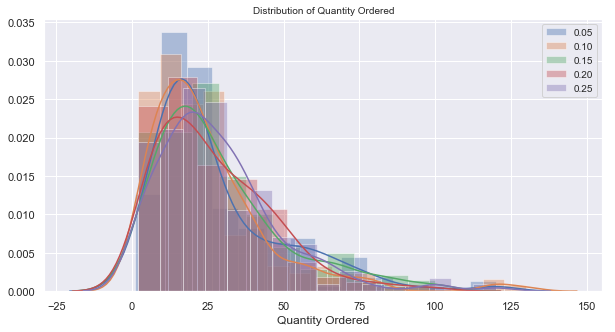

In [26]:


plt.figure(figsize = (10,5))

sns.distplot(q1_wDis['Quantity'][q1_wDis['Discount']==0.05], label = "0.05")
sns.distplot(q1_wDis['Quantity'][q1_wDis['Discount']==0.10], label = "0.10")
sns.distplot(q1_wDis['Quantity'][q1_wDis['Discount']==0.15], label = "0.15")
sns.distplot(q1_wDis['Quantity'][q1_wDis['Discount']==0.20], label = "0.20")
sns.distplot(q1_wDis['Quantity'][q1_wDis['Discount']==0.25], label = "0.25")



plt.title("Distribution of Quantity Ordered", fontsize= 10)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 10)

In [27]:
q1a_feature_groups = [ 
                       q1_wDis['Quantity'][q1_wDis['Discount']==.05], 
                       q1_wDis['Quantity'][q1_wDis['Discount']==.10], 
                       q1_wDis['Quantity'][q1_wDis['Discount']==.15], 
                       q1_wDis['Quantity'][q1_wDis['Discount']==.20], 
                       q1_wDis['Quantity'][q1_wDis['Discount']==.25] 
                     ]


for i in q1a_feature_groups:
    print(stats.normaltest(i))

NormaltestResult(statistic=63.84242740591745, pvalue=1.3702286160643066e-14)
NormaltestResult(statistic=98.50271035413209, pvalue=4.0776337983848464e-22)
NormaltestResult(statistic=38.52550343019272, pvalue=4.308173885400061e-09)
NormaltestResult(statistic=31.398997154435623, pvalue=1.519827852850104e-07)
NormaltestResult(statistic=54.44887806745976, pvalue=1.5016763972075847e-12)


groups of the different discount levels are not Gaussian

In [28]:

df_05 = q1df[q1df.Discount == 0.05]
df_10 = q1df[q1df.Discount == 0.10]
df_15 = q1df[q1df.Discount == 0.15]
df_20 = q1df[q1df.Discount == 0.20]
df_25 = q1df[q1df.Discount == 0.25]


norm_05 = create_sample_distribution(df_05.Quantity, dist_size=1000, n=1000)
norm_10 = create_sample_distribution(df_10.Quantity, dist_size=1000, n=1000)
norm_15 = create_sample_distribution(df_15.Quantity, dist_size=1000, n=1000)
norm_20 = create_sample_distribution(df_20.Quantity, dist_size=1000, n=1000)
norm_25 = create_sample_distribution(df_25.Quantity, dist_size=1000, n=1000)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


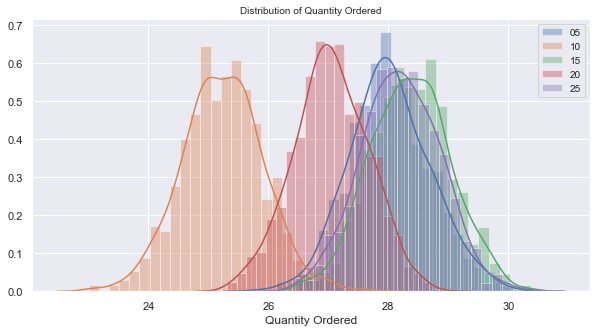

In [29]:
plt.figure(figsize = (10,5))


sns.distplot(norm_05, label = "05")
sns.distplot(norm_10, label = "10")
sns.distplot(norm_15, label = "15")
sns.distplot(norm_20, label = "20")
sns.distplot(norm_25, label = "25")

plt.title("Distribution of Quantity Ordered", fontsize= 10)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 10)

In [30]:
norm_levels = [norm_05, norm_10, norm_15, norm_20, norm_25]

for level in norm_levels:
    print(stats.normaltest(level))

NormaltestResult(statistic=2.7566837710590857, pvalue=0.2519960451282092)
NormaltestResult(statistic=4.254568154227897, pvalue=0.11916048546158234)
NormaltestResult(statistic=0.9819391387830679, pvalue=0.6120326982453836)
NormaltestResult(statistic=1.7215165747989398, pvalue=0.42284132547110087)
NormaltestResult(statistic=0.6362552799506074, pvalue=0.7275099231394381)


In [31]:
# converting the lists of resampled quantities into series


norm_05=pd.Series( norm_05, name= 'norm_05')
norm_10=pd.Series( norm_10, name= 'norm_10')
norm_15=pd.Series( norm_15, name= 'norm_15')
norm_20=pd.Series( norm_20, name= 'norm_20')
norm_25=pd.Series(norm_25, name= 'norm_25')

# combining the series into a dataFrame
norm_dis_df = pd.DataFrame(pd.concat([norm_05, norm_10, norm_15, norm_20, norm_25], axis = 1))

# using .melt() to change the datas structure into one that will allow me to compute ANOVA
norm_discount_melted_df = copy.deepcopy(pd.melt(norm_dis_df))

# renaming column names to be intuitive
norm_discount_melted_df.rename(columns = {'variable': 'Discount', 'value': 'Quantity'}, inplace=True)

#norm_discount_melted_df.replace({'Discount':{'norm_05':0.05, 'norm_10':0.10, 'norm_15':0.15, 'norm_20':0.20, 'norm_25':0.25}}, inplace = True)
norm_discount_melted_df.head()

,Discount,Quantity
0,norm_05,28.234
1,norm_05,27.915
2,norm_05,27.715
3,norm_05,27.519
4,norm_05,27.847


ANOVA Table

In [32]:
formula = "Quantity ~ C(Discount)"
           
lm = ols(formula, q1_wDis).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)


                    sum_sq     df         F    PR(>F)
C(Discount)    1159.517551    4.0  0.674103  0.610041
Residual     354768.342690  825.0       NaN       NaN


###### The ANOVA F statistic is not in the rejection region, being less than the critical value of 2.57, however, the P-value is insignificant, so we fail to reject the null that the magnitude of impact between the varying discount levels on quantities sold are equal.  

##### <font color='yellow'> Conclusion part 1b </font>

**Restate the question and hypotheses:**<br>
is there a difference in magnitude of impact on order quantities between the varying discount levels?<br>
𝐻𝑂: All discount groups have an equal impact on order quantities<br>
𝐻𝑎: Varying discount levels produce different results on order quantities<br>

There is no significant difference in order quantities between the different disscount levels.
The implication of this conclusion is that Northwind can achieve the same results with a 5% discount as a 25% discount, so, they should use the less expensive discount to buy demand.

## <font color ='lime'> Question 2 </font>
###### Are order quantities equivalent by day of the week?

$H_O$: Order quantities are uniform between days of the week <br>
$H_a$: Order quantities vary with significance between days of the week<br>

this is a two tailed test

In [33]:
data.head()

,CategoryId,CategoryName,Description,ProductId,ProductName,SupplierId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,OrderId,UnitPrice_y,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,Chai,1,10 boxes x 20 bags,18.0,39,0,10,0,10285/1,10285,14.4,45,0.2,QUICK,1,2012-08-20,2012-09-17,2012-08-26,2,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None
1,6,Meat/Poultry,Prepared meats,53,Perth Pasties,24,48 pieces,32.8,0,0,0,1,10285/53,10285,26.2,36,0.2,QUICK,1,2012-08-20,2012-09-17,2012-08-26,2,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None
2,8,Seafood,Seaweed and fish,40,Boston Crab Meat,19,24 - 4 oz tins,18.4,123,0,30,0,10285/40,10285,14.7,40,0.2,QUICK,1,2012-08-20,2012-09-17,2012-08-26,2,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None
3,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,Chai,1,10 boxes x 20 bags,18.0,39,0,10,0,10691/1,10691,18.0,30,0.0,QUICK,2,2013-10-03,2013-11-14,2013-10-22,2,810.05,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None
4,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",43,Ipoh Coffee,20,16 - 500 g tins,46.0,17,10,25,0,10691/43,10691,46.0,40,0.0,QUICK,2,2013-10-03,2013-11-14,2013-10-22,2,810.05,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None


In [34]:
q2df = copy.deepcopy(data[[ "Quantity", "OrderDate"]])
q2df.head()


,Quantity,OrderDate
0,45,2012-08-20
1,36,2012-08-20
2,40,2012-08-20
3,30,2013-10-03
4,40,2013-10-03


In [35]:
q2df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2078 entries, 0 to 2077
Data columns (total 2 columns):
Quantity     2078 non-null int64
OrderDate    2078 non-null object
dtypes: int64(1), object(1)
memory usage: 48.7+ KB


In [36]:
# we need to convert the OrderDate column from a string (object) to a DateTime type.

q2df.OrderDate = pd.to_datetime(q2df.OrderDate, infer_datetime_format=True)
q2df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2078 entries, 0 to 2077
Data columns (total 2 columns):
Quantity     2078 non-null int64
OrderDate    2078 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 48.7 KB


In [37]:
q2df['DayOfWeek'] = q2df['OrderDate'].dt.day_name()
q2df.head()

,Quantity,OrderDate,DayOfWeek
0,45,2012-08-20,Monday
1,36,2012-08-20,Monday
2,40,2012-08-20,Monday
3,30,2013-10-03,Thursday
4,40,2013-10-03,Thursday


C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


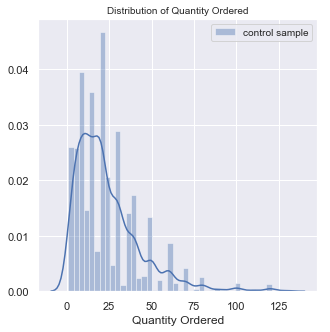

In [38]:
plt.figure(figsize = (5,5))
sns.distplot(q2df.Quantity, label = "control sample")

plt.title("Distribution of Quantity Ordered", fontsize= 10)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 10)

will need to resample, but first, split data by features

In [39]:
formula = "Quantity ~ C(DayOfWeek)"
           
lm = ols(formula, q2df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                     sum_sq      df         F    PR(>F)
C(DayOfWeek)     636.009193     4.0  0.433043  0.784845
Residual      761153.128921  2073.0       NaN       NaN


##### <font color='yellow'> Conclusion Question 2 </font>

With a P-value greater than alpha of 0.05, we are not able to reject the null hypotheses that order quantities are uniform through days of the week.

## <font color ='lime'> Question 3 </font>
Are the distributions of order Quanitites by time-in-job similar between employees?

$H_O$: all sales peoples performance are identical <br>
$H_a$: some sales people do better than others and some do worse<br>

this is a two tailed test

In [107]:
q3df = copy.deepcopy(data[['EmployeeId', 'Quantity', ]])

print(q3df.EmployeeId.value_counts())
print(q3df.head())

4.0    420
1.0    345
3.0    321
8.0    260
2.0    241
7.0    176
6.0    168
5.0    117
9.0    107
Name: EmployeeId, dtype: int64
   EmployeeId  Quantity
0         1.0      45.0
1         1.0      36.0
2         1.0      40.0
3         1.0      50.0
4         1.0      20.0


In [108]:
data.head(2)

,CategoryId,CategoryName,Description,ProductId,ProductName,SupplierId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,OrderId,UnitPrice_y,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,CompanyName,ContactName,ContactTitle,Address_x,City_x,Region_x,PostalCode_x,Country_x,Phone,Fax,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address_y,City_y,Region_y,PostalCode_y,Country_y,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1.0,Beverages,"Soft drinks, coffees, teas, beers, and ales",1.0,Chai,1.0,10 boxes x 20 bags,18.0,39.0,0.0,10.0,0.0,10285/1,10285.0,14.4,45.0,0.2,QUICK,1.0,2012-08-20,2012-09-17,2012-08-26,2.0,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2004-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,6.0,Meat/Poultry,Prepared meats,53.0,Perth Pasties,24.0,48 pieces,32.8,0.0,0.0,0.0,1.0,10285/53,10285.0,26.2,36.0,0.2,QUICK,1.0,2012-08-20,2012-09-17,2012-08-26,2.0,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2004-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp


In [109]:
q3df = copy.deepcopy(data[['Quantity', 'EmployeeId', 'HireDate', 'OrderDate' ]])
q3df.head()


,Quantity,EmployeeId,HireDate,OrderDate
0,45.0,1.0,2004-05-01,2012-08-20
1,36.0,1.0,2004-05-01,2012-08-20
2,40.0,1.0,2004-05-01,2012-08-20
3,50.0,1.0,2004-05-01,2014-04-01
4,20.0,1.0,2004-05-01,2014-04-01


In [110]:
q3df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2161 entries, 0 to 2160
Data columns (total 4 columns):
Quantity      2155 non-null float64
EmployeeId    2155 non-null float64
HireDate      2155 non-null object
OrderDate     2155 non-null object
dtypes: float64(2), object(2)
memory usage: 84.4+ KB


In [115]:
q3df.HireDate = pd.to_datetime(q3df.HireDate, infer_datetime_format=True)
q3df.OrderDate = pd.to_datetime(q3df.OrderDate, infer_datetime_format=True)

In [116]:
q3df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2161 entries, 0 to 2160
Data columns (total 4 columns):
Quantity      2155 non-null float64
EmployeeId    2155 non-null float64
HireDate      2155 non-null datetime64[ns]
OrderDate     2155 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2)
memory usage: 84.4 KB


In [149]:
#from dateutil import relativedelta
#from dateutil.relativedelta import *
from dateutil.relativedelta import relativedelta

#q3df['TimeInJob'] = (q3df['OrderDate'] - q3df['HireDate'] )
#q3df['yrsInJob'] = relativedelta(q3df['OrderDate'], q3df['HireDate'])

q3df['MonthsInJob'] = round(((q3df.OrderDate - q3df.HireDate)/np.timedelta64(1,'M')),0)



In [151]:
#q3df.drop(['TimeInJob', 'yrsInJob'], axis= 1, inplace = True)
q3df.head()

,Quantity,EmployeeId,HireDate,OrderDate,MonthsInJob
0,45.0,1.0,2004-05-01,2012-08-20,100.0
1,36.0,1.0,2004-05-01,2012-08-20,100.0
2,40.0,1.0,2004-05-01,2012-08-20,100.0
3,50.0,1.0,2004-05-01,2014-04-01,119.0
4,20.0,1.0,2004-05-01,2014-04-01,119.0


In [181]:
#print(stats.normaltest(log_e1))

monthly_sales_sum_by_employee = ((q3df.groupby(['EmployeeId', 'MonthsInJob'], as_index = False)['Quantity'].sum()))
print(type(monthly_sales_sum))
monthly_sales_sum.head()


<class 'pandas.core.frame.DataFrame'>


,EmployeeId,MonthsInJob,Quantity
0,1.0,99.0,194.0
1,1.0,100.0,216.0
2,1.0,101.0,284.0
3,1.0,102.0,192.0
4,1.0,103.0,331.0


In [182]:
monthly_sales_sum_by_employee_DF = copy.deepcopy(monthly_sales_sum_by_employee)

In [194]:
empl_1 = monthly_sales_sum_by_employee_DF[monthly_sales_sum_by_employee_DF['EmployeeId']==1]
empl_1.drop(['EmployeeId'], axis = 1, inplace = True)

empl_2 = monthly_sales_sum_by_employee_DF[monthly_sales_sum_by_employee_DF['EmployeeId']==2]
empl_2.drop(['EmployeeId'], axis = 1, inplace = True)

empl_3 = monthly_sales_sum_by_employee_DF[monthly_sales_sum_by_employee_DF['EmployeeId']==3]
empl_3.drop(['EmployeeId'], axis = 1, inplace = True)

empl_4 = monthly_sales_sum_by_employee_DF[monthly_sales_sum_by_employee_DF['EmployeeId']==4]
empl_4.drop(['EmployeeId'], axis = 1, inplace = True)

empl_5 = monthly_sales_sum_by_employee_DF[monthly_sales_sum_by_employee_DF['EmployeeId']==5]
empl_5.drop(['EmployeeId'], axis = 1, inplace = True)

empl_6 = monthly_sales_sum_by_employee_DF[monthly_sales_sum_by_employee_DF['EmployeeId']==6]
empl_6.drop(['EmployeeId'], axis = 1, inplace = True)

empl_7 = monthly_sales_sum_by_employee_DF[monthly_sales_sum_by_employee_DF['EmployeeId']==7]
empl_7.drop(['EmployeeId'], axis = 1, inplace = True)

empl_8 = monthly_sales_sum_by_employee_DF[monthly_sales_sum_by_employee_DF['EmployeeId']==8]
empl_8.drop(['EmployeeId'], axis = 1, inplace = True)

empl_9 = monthly_sales_sum_by_employee_DF[monthly_sales_sum_by_employee_DF['EmployeeId']==9]
empl_9.drop(['EmployeeId'], axis = 1, inplace = True)


C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [193]:
empl_1.head()

,MonthsInJob,Quantity
0,99.0,194.0
1,100.0,216.0
2,101.0,284.0
3,102.0,192.0
4,103.0,331.0


In [ ]:
plt.figure(figsize = (5,5))
sns.distplot(q2df.Quantity, label = "control sample")

plt.title("Distribution of Quantity Ordered", fontsize= 10)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 10)

### other version of question 3

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


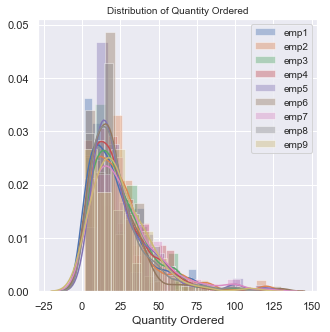

In [61]:
plt.figure(figsize = (5,5))
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==1], label = "emp1")
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==2], label = "emp2")
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==3], label = "emp3")
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==4], label = "emp4")
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==5], label = "emp5")
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==6], label = "emp6")
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==7], label = "emp7")
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==8], label = "emp8")
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==9], label = "emp9")

plt.title("Distribution of Quantity Ordered", fontsize= 10)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 10)

In [54]:
log_e1 = np.log(q3df['Quantity'][q3df['EmployeeId']==1])
log_e2 = np.log(q3df['Quantity'][q3df['EmployeeId']==2])
log_e3 = np.log(q3df['Quantity'][q3df['EmployeeId']==3])
log_e4 = np.log(q3df['Quantity'][q3df['EmployeeId']==4])
log_e5 = np.log(q3df['Quantity'][q3df['EmployeeId']==5])
log_e6 = np.log(q3df['Quantity'][q3df['EmployeeId']==6])
log_e7 = np.log(q3df['Quantity'][q3df['EmployeeId']==7])
log_e8 = np.log(q3df['Quantity'][q3df['EmployeeId']==8])
log_e9 = np.log(q3df['Quantity'][q3df['EmployeeId']==9])



C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


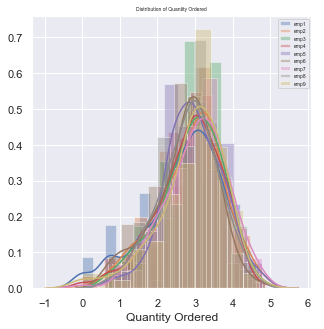

In [62]:
plt.figure(figsize = (5,5))

sns.distplot(log_e1, label = "emp1")
sns.distplot(log_e2, label = "emp2")
sns.distplot(log_e3, label = "emp3")
sns.distplot(log_e4, label = "emp4")
sns.distplot(log_e5, label = "emp5")
sns.distplot(log_e6, label = "emp6")
sns.distplot(log_e7, label = "emp7")
sns.distplot(log_e8, label = "emp8")
sns.distplot(log_e9, label = "emp9")

plt.title("Distribution of Quantity Ordered", fontsize= 5)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 5)

In [63]:
print(stats.normaltest(log_e1))
print(stats.normaltest(log_e2))
print(stats.normaltest(log_e3))
print(stats.normaltest(log_e4))
print(stats.normaltest(log_e5))
print(stats.normaltest(log_e6))
print(stats.normaltest(log_e7))
print(stats.normaltest(log_e8))
print(stats.normaltest(log_e9))

NormaltestResult(statistic=23.682900876631358, pvalue=7.199849475684884e-06)
NormaltestResult(statistic=9.76437991929481, pvalue=0.007580395077473389)
NormaltestResult(statistic=13.428220430138076, pvalue=0.0012136654328390895)
NormaltestResult(statistic=28.141248688398374, pvalue=7.748283281467563e-07)
NormaltestResult(statistic=1.2989083264383154, pvalue=0.5223308063299898)
NormaltestResult(statistic=7.813039936006895, pvalue=0.02011036413897069)
NormaltestResult(statistic=7.921905533962878, pvalue=0.01904496023541715)
NormaltestResult(statistic=3.6768329431861853, pvalue=0.15906911724010822)
NormaltestResult(statistic=20.663728398616882, pvalue=3.257829791806402e-05)


In [66]:
# ReSE1 = ReSamplEmployee1

ReSE1 = create_sample_distribution(q3df['Quantity'][q3df['EmployeeId']==1], dist_size=1000, n=1000)
ReSE2 = create_sample_distribution(q3df['Quantity'][q3df['EmployeeId']==2], dist_size=1000, n=1000)
ReSE3 = create_sample_distribution(q3df['Quantity'][q3df['EmployeeId']==3], dist_size=1000, n=1000)
ReSE4 = create_sample_distribution(q3df['Quantity'][q3df['EmployeeId']==4], dist_size=1000, n=1000)
ReSE5 = create_sample_distribution(q3df['Quantity'][q3df['EmployeeId']==5], dist_size=1000, n=1000)
ReSE6 = create_sample_distribution(q3df['Quantity'][q3df['EmployeeId']==6], dist_size=1000, n=1000)
ReSE7 = create_sample_distribution(q3df['Quantity'][q3df['EmployeeId']==7], dist_size=1000, n=1000)
ReSE8 = create_sample_distribution(q3df['Quantity'][q3df['EmployeeId']==8], dist_size=1000, n=1000)
ReSE9 = create_sample_distribution(q3df['Quantity'][q3df['EmployeeId']==9], dist_size=1000, n=1000)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


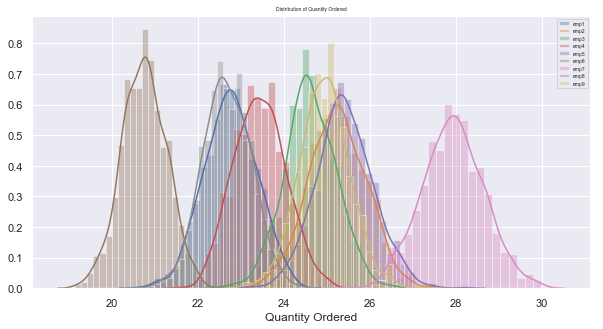

In [69]:
plt.figure(figsize = (10,5))

sns.distplot(ReSE1, label = "emp1")
sns.distplot(ReSE2, label = "emp2")
sns.distplot(ReSE3, label = "emp3")
sns.distplot(ReSE4, label = "emp4")
sns.distplot(ReSE5, label = "emp5")
sns.distplot(ReSE6, label = "emp6")
sns.distplot(ReSE7, label = "emp7")
sns.distplot(ReSE8, label = "emp8")
sns.distplot(ReSE9, label = "emp9")

plt.title("Distribution of Quantity Ordered", fontsize= 5)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 5)

In [70]:
print(stats.normaltest(ReSE1))
print(stats.normaltest(ReSE2))
print(stats.normaltest(ReSE3))
print(stats.normaltest(ReSE4))
print(stats.normaltest(ReSE5))
print(stats.normaltest(ReSE6))
print(stats.normaltest(ReSE7))
print(stats.normaltest(ReSE8))
print(stats.normaltest(ReSE9))

NormaltestResult(statistic=2.0554825426390324, pvalue=0.35781425381509696)
NormaltestResult(statistic=0.21966977376280597, pvalue=0.8959820614762931)
NormaltestResult(statistic=1.7225123321549676, pvalue=0.4226308541898951)
NormaltestResult(statistic=7.541058726428127, pvalue=0.02303986360223017)
NormaltestResult(statistic=6.567851909700549, pvalue=0.037480819575187015)
NormaltestResult(statistic=0.5154734923491388, pvalue=0.7727986475310592)
NormaltestResult(statistic=0.2993539873582073, pvalue=0.8609860354468822)
NormaltestResult(statistic=0.20589768809101014, pvalue=0.902173123828343)
NormaltestResult(statistic=4.806275923748421, pvalue=0.09043372998485487)


In [78]:

# convert lists of re-sampled normalized quantities by employe into pandas Series so we can put them in a singular DataFrame
ReSE1 = pd.Series(ReSE1, name = 'ReSE1')
ReSE2 = pd.Series(ReSE2, name = 'ReSE2')
ReSE3 = pd.Series(ReSE3, name = 'ReSE3')
ReSE4 = pd.Series(ReSE4, name = 'ReSE4')
ReSE5 = pd.Series(ReSE5, name = 'ReSE5')
ReSE6 = pd.Series(ReSE6, name = 'ReSE6')
ReSE7 = pd.Series(ReSE7, name = 'ReSE7')
ReSE8 = pd.Series(ReSE8, name = 'ReSE8')
ReSE9 = pd.Series(ReSE9, name = 'ReSE9')

# normalized_employee_quantities
norm_empl_quant = pd.DataFrame(pd.concat([ReSE1, ReSE2, ReSE3, ReSE4, ReSE5, ReSE6, ReSE7, ReSE8, ReSE9], axis = 1))

norm_empl_quant_melted = copy.deepcopy(pd.melt(norm_empl_quant))

# renaming column names to be intuitive
norm_empl_quant_melted.rename(columns = {'variable': 'Employee', 'value': 'Quantity'}, inplace=True)

norm_empl_quant_melted.head()

,Employee,Quantity
0,ReSE1,22.882
1,ReSE1,23.015
2,ReSE1,22.725
3,ReSE1,23.222
4,ReSE1,21.731


In [80]:
formula = "Quantity ~ C(Employee)"
           
lm = ols(formula, norm_empl_quant_melted).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                   sum_sq      df             F  PR(>F)
C(Employee)  34118.567213     8.0  11351.481825     0.0
Residual      3377.973494  8991.0           NaN     NaN
